# Optical Character Recognition with OpenCV and Tesseract 
Optical Character Recognition (OCR) is a technology that extracts text from images or scanned documents and converts that text into machine-readable text.

OCR is primarily used to reduce human effort. 

A few use cases are:

**Data Entry** – We can eliminate the tedious tasks of manual data entry.

**Client Onboarding** – OCR can be used in extracting personal information from identity documents for remote onboarding without needing a front desk.

**Receipt Clearing and Automated Invoice Processing** – With OCR we can verify receipts and automate invoice data extraction.

**Digital Archiving** – We can provide better access to data by digitizing old paper archives.

### Importing required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pytesseract

Pytesseract is an optical character recognition (OCR) tool for Python. Pytesseract serves as a wrapper for the Tesseract-OCR Engine. It can read and recognize text embedded in images.

### Let's work with an example.

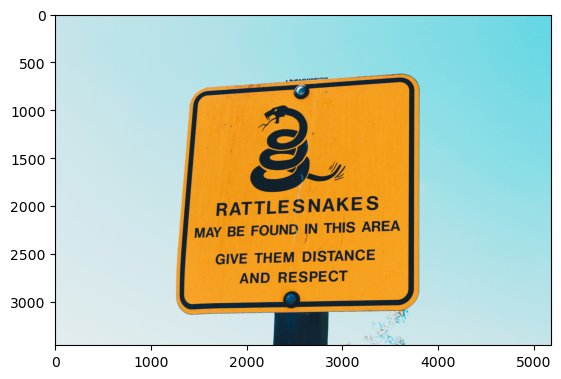

In [2]:
image_original = plt.imread('./image/19.jpg')
plt.imshow(image_original)

### Setting the path for tesseract

Setting the path according to the system configuration is required to avoid error.

In [3]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [4]:
def text_extract(img):
    text = pytesseract.image_to_string(img) 
    print(' '.join(text.split('\n')))

### The output for the original image

In [5]:
text_extract(image_original)

GIVE THEM DISTANCE ND RESPECT  


### Text Detection

There are a variety of reasons why we might not get good-quality output from Tesseract.

OCR has two parts to it. The first part is text detection, i.e. locating the text within the image. The second part is text recognition.

Tesseract needs a fairly clean input image. Unfortunately, most images will contain other objects and not just clean text. To improve output accuracy, we need to make sure that the image is appropriately pre-processed.

### The output for the cropped image

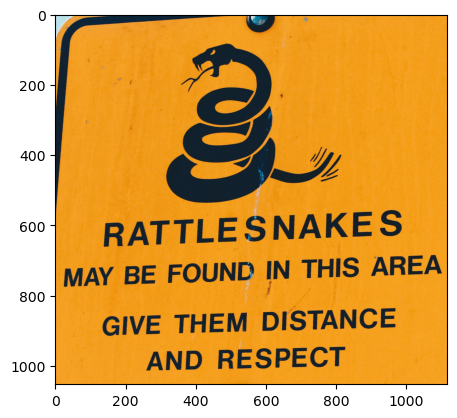

In [6]:
image_crop = plt.imread('./image/26.jpg')
plt.imshow(image_crop)

In [7]:
text_extract(image_crop)

Cons RATTLESNAKES MAY BE FOUND IN THIS AREA  GIVE THEM DISTANCE AND RESPECT 


Although the result was better than the original image, Tesseract didn't produce accurate results.

### The output for the cropped image of Text

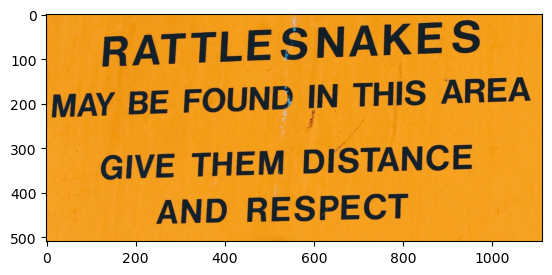

In [8]:
image_crop_text = plt.imread('./image/21.jpg')
plt.imshow(image_crop_text)

In [9]:
text_extract(image_crop_text)

- RATTLESNAKES MAY BE FOUND | IN THIS AREA  GIVE THEM DISTANCE AND RESPECT) —— 


Because of random variations of brightness and colour in the image, extra characters have been erroneously picked up as well.

Let's convert the image to black and white and see if it improves the accuracy.

In [10]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [11]:
def display_gray_image(img):
    plt.imshow(img,cmap='gray')

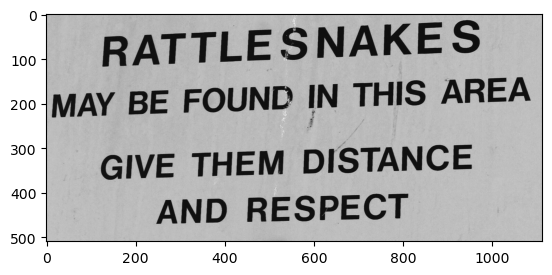

In [12]:
image_gray = grayscale(image_crop_text)
display_gray_image(image_gray)

In [13]:
text_extract(image_gray)

RATTLESNAKES MAY BE FOUND IN THIS AREA  GIVE THEM DISTANCE AND RESPECT 


### OpenCV EAST : Efficient and Accurate Scene Text Detector

Optical Character Recognition remains a challenging problem when text occurs in unconstrained environments, like natural scenes, due to geometrical distortions, complex backgrounds, and diverse fonts. Therefore, it becomes necessary to have a good text detection system that can detect text which can then be easily extracted. With the advent of deep learning, it has become possible to get better and more generalized solutions to this problem.

EAST is a simple end-to-end powerful pipeline that yields fast and accurate text detection in natural scenes. The pipeline directly predicts words or text lines of arbitrary orientations with a single neural network, without unnecessary steps.

We will use the EAST model to detect the bounding box (x, y-coordinates) of text ROIs. We’ll then pass text ROIs into Tesseract text recognition algorithm.

In [14]:
algo = 'frozen_east_text_detection.pb'

We will use the cv2.dnn.ReadNet() function for loading the pre-trained Tensorflow Network.

In [15]:
net = cv2.dnn.readNet(algo)

In [16]:
image_new = image_original.copy()

In [17]:
H,W =image_new.shape[:2]

cv2.dnn.blobFromImage() is used to create a 4-D input blob for feeding the image to the network.

The parameter for this function are as follows:

1) The first argument is the image that we need to convert.
2) The second argument is the scale factor.
3) The third argument is the size of the network.
4) The fourth argument is the mean that should be subtracted from each image since this was used while training the model.
5) The fifth argument is to swap R and B channels.

In [18]:
blob = cv2.dnn.blobFromImage(image_new, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True)

We will set the blob as an input for the network using the setInput() function.

In [19]:
net.setInput(blob)

We expect two outputs from the EAST model: 
1. Probability scores for the region with text. 
2. Geometry: Coordinates of the bounding box of text

In [20]:
scores, geometry = net.forward(["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"])

In [21]:
Rows, Cols = scores.shape[2:4]

In [22]:
bounding_box = []
confidences = []

bounding_box : Stores the bounding box (x, y)-coordinates for text regions

confidences : Stores the probability associated with each of the bounding boxes

In [23]:
for y in range(0, Rows):
    #extracting the probabilities
    scoresData = scores[0, 0, y] 
    #extracting geometry data for the row y
    x0 = geometry[0, 0, y]
    x1 = geometry[0, 1, y]
    x2 = geometry[0, 2, y]
    x3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    
    for x in range(0, Cols):
        if scoresData[x] < 0.5:
            #ignoring low probability
            continue
        # the feature map is 4 times smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)
        # extracting the rotation angle for the prediction
        angle = anglesData[x]
        # computing the sin and cosine
        cos = np.cos(angle)
        sin = np.sin(angle)
        #deriving the width and height of the bounding box
        h = x0[x] + x2[x]
        w = x1[x] + x3[x]
        # computing starting and ending (x, y)-coordinates for bounding box
        endX = int(offsetX + (cos * x1[x]) + (sin * x2[x]))
        endY = int(offsetY - (sin * x1[x]) + (cos * x2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
        # appending bounding box coordinates and probability score
        bounding_box.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

To suppress weak overlapping bounding boxes we will apply non-maxima suppression to our bounding boxes.

In [24]:
from imutils.object_detection import non_max_suppression

In [25]:
boxes = non_max_suppression(np.array(bounding_box), probs=confidences)

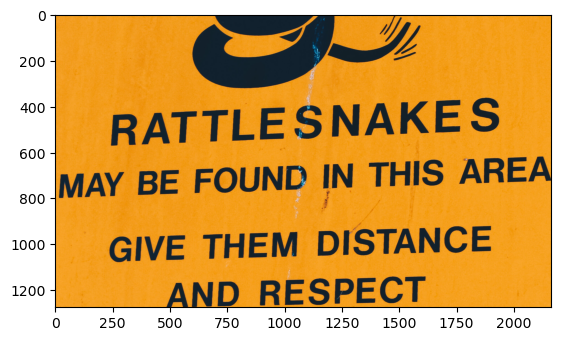

In [26]:
roi = image_original[boxes[:,1].min():boxes[:,3].max(),boxes[:,0].min():boxes[:,2].max()]
plt.imshow(roi)

Now that we have derived the ROI after applying non-max-suppression, we can extract the text using tesseract.

In [27]:
text_extract(roi)

RATTLESNAKES MAY BE FOUND IN THIS AREA  GIVE THEM DISTANCE AND RESPECT 


### Results

We used OpenCV EAST model for text detection and tesseract for text recognition.

We have not considered images with skewed text due to its complexity to implement. In real life scenarios where the text is rotated, the above code might not work well.